**Trenujemy model regresji korzystając z danych półmaratonu wrocławskiego 2023 i 2024.**

**Do wytrenowania modelu potrzebujemy danych takich jak:**
* wiek 
* płeć, 
* tempo biegu na 5km

**Na podstawie tych danych nasz model ma oszacować czas ukończenia półmaratonu.**

In [2]:
import os
import boto3
from dotenv import load_dotenv
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, pull, save_model


In [3]:
load_dotenv()

True

In [4]:
s3 = boto3.client(
    "s3",
)

In [5]:
BUCKET_NAME = "maratonymateusz"

In [23]:
!pip install --quiet s3fs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.37.10 requires botocore<1.38.0,>=1.37.10, but you have botocore 1.37.3 which is incompatible.


In [6]:
df_2023 = pd.read_csv(f"s3://{BUCKET_NAME}/data/halfmarathon_2023.csv")
df_2024 = pd.read_csv(f"s3://{BUCKET_NAME}/data/halfmarathon_2024.csv")

In [7]:
# Zamieniamy Rocznik zawodnika na ich wiek poprzez genialną metodą odejmowania :)
df_2023['Wiek'] = 2023 - df_2023['Rocznik']
df_2024['Wiek'] = 2024 - df_2024['Rocznik']

In [8]:
# Łączymy obydwa pliki z danymi
df_full = pd.concat([df_2023, df_2024], ignore_index=True)

In [9]:
df_full.isna().sum() / len(df_full) * 100

Unnamed: 0                    0.000000
Miejsce                      15.972127
Numer startowy                0.000000
Imię                          0.000000
Nazwisko                      0.000000
Miasto                       19.050872
Kraj                         15.972127
Drużyna                      61.734299
Płeć                          0.050098
Płeć Miejsce                 15.972127
Kategoria wiekowa             0.141185
Kategoria wiekowa Miejsce    16.063214
Rocznik                       2.208863
5 km Czas                    16.149747
5 km Miejsce Open            16.149747
5 km Tempo                   16.149747
10 km Czas                   16.076878
10 km Miejsce Open           16.076878
10 km Tempo                  16.222617
15 km Czas                   16.072323
15 km Miejsce Open           16.072323
15 km Tempo                  16.140639
20 km Czas                   16.022225
20 km Miejsce Open           16.022225
20 km Tempo                  16.099649
Tempo Stabilność         

In [10]:
# Tworzymy tylko taki dataframe dla których będziemy trenować model, wg założenia: płeć, czas, wiek, tempo na 5km
df = df_full[["Płeć", "5 km Tempo", "Czas", "Wiek"]]

In [11]:
# Sprawdzamy procentowo brakujace dane
df.isna().sum() / len(df) * 100

Płeć           0.050098
5 km Tempo    16.149747
Czas          15.972127
Wiek           2.208863
dtype: float64

In [12]:
# Usuwamy brakujące wartości
df = df.dropna()

In [13]:
exp = setup(data = df, target="Czas", session_id=33)

,Description,Value
0,Session id,33
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17927, 4)"
4,Transformed data shape,"(17927, 4)"
5,Transformed train set shape,"(12548, 4)"
6,Transformed test set shape,"(5379, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [14]:
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:21:00
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,300.3821,171828.3336,414.2942,0.8827,0.0525,0.0393,0.2450
lightgbm,Light Gradient Boosting Machine,303.5118,176260.8676,419.6328,0.8796,0.0531,0.0397,0.1330
catboost,CatBoost Regressor,303.5533,176520.5353,419.9292,0.8795,0.0531,0.0397,1.5560
ridge,Ridge Regression,303.3557,183728.7987,427.8703,0.8747,0.0579,0.0396,0.0280
lar,Least Angle Regression,303.3501,183728.8093,427.8698,0.8747,0.0579,0.0396,0.0270
llar,Lasso Least Angle Regression,303.3870,183725.3917,427.8701,0.8747,0.0580,0.0396,0.0270
br,Bayesian Ridge,303.3517,183728.8381,427.8700,0.8747,0.0579,0.0396,0.0270
lr,Linear Regression,303.3501,183728.8093,427.8698,0.8747,0.0579,0.0396,0.5790
lasso,Lasso Regression,303.3870,183725.3726,427.8700,0.8747,0.0580,0.0396,0.0290
huber,Huber Regressor,298.6707,186069.2028,430.6085,0.8731,0.0582,0.0387,0.0550


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

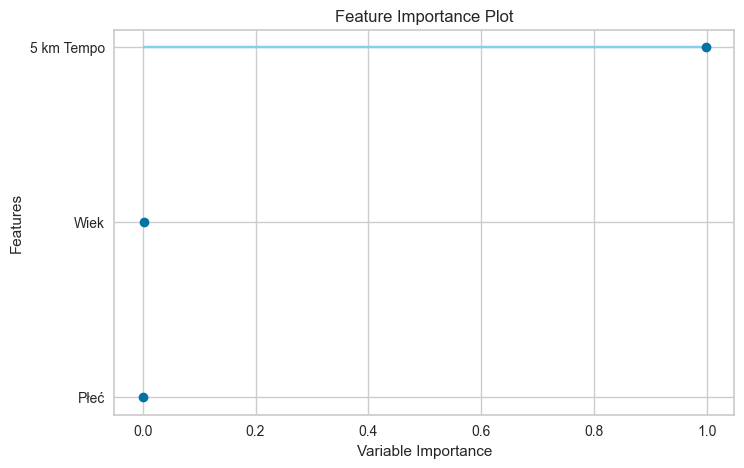

In [15]:
exp.plot_model(best_model, plot='feature')

In [16]:
# Walczymy z outliersami, czyli wyrzucamy wartości odstające - jednostki wybitne i mniej wybitne
df_copy = df.copy()


In [17]:
Q1 = df_copy["Czas"].quantile(0.25)
Q3 = df_copy["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

no_outliers_df = df_copy[~((df_copy["Czas"] < lower_bound) | (df_copy["Czas"] > upper_bound))]

In [18]:
no_outliers_exp = setup(data = no_outliers_df, target="Czas", session_id=33)

,Description,Value
0,Session id,33
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17687, 4)"
4,Transformed data shape,"(17687, 4)"
5,Transformed train set shape,"(12380, 4)"
6,Transformed test set shape,"(5307, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [19]:
no_outliers_best_model = no_outliers_exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,291.7934,158388.4911,397.8359,0.8795,0.0512,0.0385,0.2420
lightgbm,Light Gradient Boosting Machine,294.6988,161569.4508,401.8115,0.8771,0.0517,0.0389,0.1340
catboost,CatBoost Regressor,296.5114,163322.3988,403.9983,0.8758,0.0520,0.0391,1.5600
ridge,Ridge Regression,293.8647,165111.3285,405.9275,0.8743,0.0568,0.0387,0.0260
lar,Least Angle Regression,293.8589,165111.3078,405.9273,0.8743,0.0568,0.0387,0.0260
llar,Lasso Least Angle Regression,293.8752,165113.1101,405.9314,0.8743,0.0570,0.0387,0.0360
br,Bayesian Ridge,293.8604,165111.3263,405.9274,0.8743,0.0568,0.0387,0.0260
lr,Linear Regression,293.8589,165111.3078,405.9273,0.8743,0.0568,0.0387,0.7480
lasso,Lasso Regression,293.8752,165113.0997,405.9314,0.8743,0.0570,0.0387,0.0280
huber,Huber Regressor,289.3237,167484.7215,408.8489,0.8725,0.0573,0.0378,0.0510


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

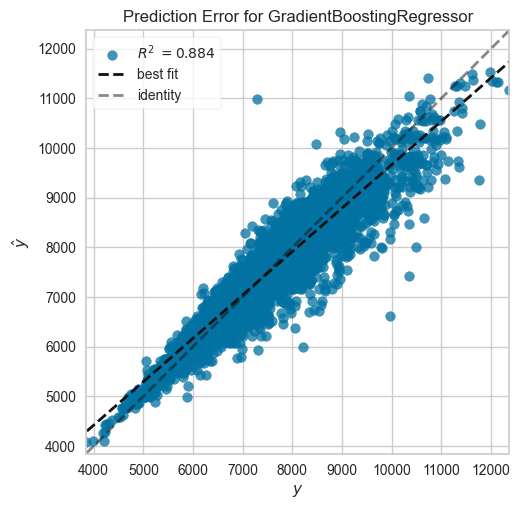

In [20]:
exp.plot_model(best_model, plot='error')

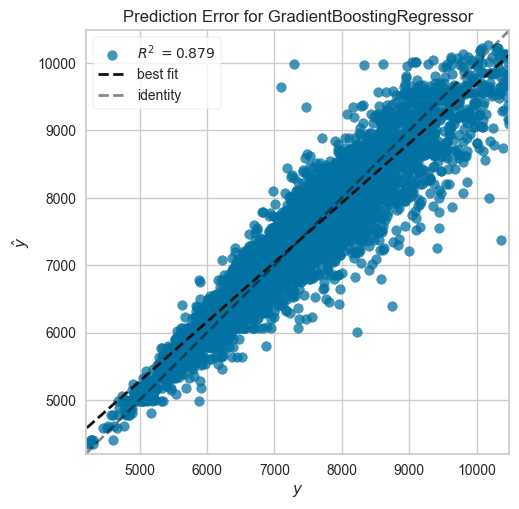

In [21]:
no_outliers_exp.plot_model(no_outliers_best_model, plot='error')

In [26]:
# Robimy optymalizację hiperparametrów - tuning

tuned_gbr_model = exp.tune_model(best_model, n_iter=50, optimize='R2')
results1 = pull()

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
# Optymalizacja dla no_outliers

tuned_no_outliers_gbr_model = exp.tune_model(no_outliers_best_model, n_iter=50, optimize='R2')
results2 = pull()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,300.0116,166890.5635,408.5224,0.8921,0.0520,0.0394
1,289.6465,159484.9167,399.3556,0.8897,0.0510,0.0382
2,312.7127,181913.5524,426.5133,0.8802,0.0537,0.0406
3,298.6136,163221.8186,404.0072,0.8911,0.0510,0.0392
4,305.2541,180130.1803,424.4175,0.8748,0.0544,0.0399
5,300.3704,173395.3992,416.4077,0.8808,0.0518,0.0389
6,304.1010,170802.0483,413.2820,0.8747,0.0529,0.0400
7,291.2525,163980.9977,404.9457,0.8921,0.0505,0.0377
8,312.1280,199416.6905,446.5610,0.8647,0.0566,0.0408


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
goat_model = exp.compare_models([best_model, no_outliers_best_model, tuned_gbr_model, tuned_no_outliers_gbr_model])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,300.3821,171828.3336,414.2942,0.8827,0.0525,0.0393,0.2830
1,Gradient Boosting Regressor,300.3821,171828.3336,414.2942,0.8827,0.0525,0.0393,0.2640
2,Gradient Boosting Regressor,300.3821,171828.3336,414.2942,0.8827,0.0525,0.0393,0.2600
3,Gradient Boosting Regressor,300.3821,171828.3336,414.2942,0.8827,0.0525,0.0393,0.2630


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [29]:
exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,298.4866,170088.0955,412.4174,0.8844,0.0521,0.0390


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7806.263196
11932,M,5.500000,19.0,6738.0,7275.997903
10939,M,4.746666,39.0,6400.0,6250.075462
12960,M,5.020000,53.0,7025.0,6547.101718
14791,K,5.840000,25.0,7540.0,7752.186445
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7898.283993
7028,K,6.183333,46.0,8743.0,8207.944846
9459,M,4.343333,40.0,5631.0,5751.999886
19056,M,5.626667,30.0,10359.0,7415.670065


In [30]:
exp.predict_model(no_outliers_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,299.4452,172810.9710,415.7054,0.8825,0.0520,0.0389


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7825.197816
11932,M,5.500000,19.0,6738.0,7282.937960
10939,M,4.746666,39.0,6400.0,6238.407616
12960,M,5.020000,53.0,7025.0,6564.331045
14791,K,5.840000,25.0,7540.0,7706.807423
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7899.148114
7028,K,6.183333,46.0,8743.0,8271.349923
9459,M,4.343333,40.0,5631.0,5757.363421
19056,M,5.626667,30.0,10359.0,7381.960879


In [31]:
exp.predict_model(goat_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,298.4866,170088.0955,412.4174,0.8844,0.0521,0.0390


,Płeć,5 km Tempo,Wiek,Czas,prediction_label
4984,K,5.896667,45.0,7538.0,7806.263196
11932,M,5.500000,19.0,6738.0,7275.997903
10939,M,4.746666,39.0,6400.0,6250.075462
12960,M,5.020000,53.0,7025.0,6547.101718
14791,K,5.840000,25.0,7540.0,7752.186445
...,...,...,...,...,...
17027,K,5.923333,57.0,8364.0,7898.283993
7028,K,6.183333,46.0,8743.0,8207.944846
9459,M,4.343333,40.0,5631.0,5751.999886
19056,M,5.626667,30.0,10359.0,7415.670065


In [33]:
best_final_model = exp.finalize_model(goat_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['5 km Tempo', 'Wiek'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=OrdinalEncoder(cols=['Płeć'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'Płeć',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': K      0
M      1
NaN   -1
dtype: int64}]))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=33))])

In [34]:
exp.save_model(best_final_model, "best_model", verbose=False);

In [35]:
# Przesyłamy model do bucketu

s3.upload_file(
    Filename="best_model.pkl",
    Bucket=BUCKET_NAME,
    Key="data/best_model.pkl"
)